# **RNA Classification Homework - Pierre Pauchet**

# Setup

In [103]:
## Dependencies
import torch 
import gc
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torchmetrics import F1Score
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from scipy.stats import randint
from sklearn.tree import export_graphviz
from IPython.display import Image


In [104]:
## Hyperparameters 
EPOCHS=200
HIDDEN_UNITS=150
CLASSES=3
SEED=55
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4

In [105]:
## Device agnostic coding 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [106]:
## Importing the data from raw files
ra_train_data=pd.read_csv("ra_train_data.tsv", sep= "\t")
ra_test_data=pd.read_csv("ra_test_data.tsv", sep= "\t")
healthy_train_data=pd.read_csv("healthy_train_data.tsv", sep= "\t")
healthy_test_data=pd.read_csv("healthy_test_data.tsv", sep= "\t")
sle_test_data=pd.read_csv("sle_test_data.tsv", sep= "\t")
sle_train_data=pd.read_csv("sle_train_data.tsv", sep= "\t")

# Data Processing, cleaning and visualisation

In [107]:
# Labelling our data
ra_train_data["label"]=1
ra_test_data["label"]=1
healthy_train_data["label"]=0
healthy_test_data["label"]=0
sle_train_data["label"]=2
sle_test_data["label"]=2
sle_train_data.head()

,Unnamed: 0,DDX11L1,WASH7P,MIR6859-1,MIR1302-2HG,MIR1302-2,FAM138A,OR4F5,WASH9P,LOC729737,...,TRNH,TRNS2,TRNL2,ND5,ND6,TRNE,CYTB,TRNT,TRNP,label
0,GSE63755_GSM1556699,0.0,5.085,4.574,0.0,0.0,0.0,0.0,0.0,0.0,...,27.74,38.52,31.00,1016.0,1015.0,606.1,1110.0,64.89,120.30,2
1,GSE63755_GSM1556700,0.0,5.090,4.004,0.0,0.0,0.0,0.0,0.0,0.0,...,30.16,42.52,29.31,1389.0,1458.0,777.6,1715.0,83.09,135.60,2
2,GSE63755_GSM1556701,0.0,7.666,4.897,0.0,0.0,0.0,0.0,0.0,0.0,...,33.78,43.61,29.84,524.9,599.5,280.3,808.0,17.89,24.93,2
3,GSE63755_GSM1556702,0.0,4.574,3.967,0.0,0.0,0.0,0.0,0.0,0.0,...,51.72,68.58,49.68,1703.0,1660.0,946.3,1823.0,109.70,168.40,2
4,GSE63755_GSM1556703,0.0,6.321,4.730,0.0,0.0,0.0,0.0,0.0,0.0,...,40.86,49.07,35.98,1244.0,1258.0,700.1,1466.0,92.31,160.60,2


In [108]:
## Data Preprocessing and visualisation
# Scanning for doublons 
np.max(ra_train_data.iloc[:,0].value_counts()), np.max(ra_test_data.iloc[:,0].value_counts()),np.max(healthy_train_data.iloc[:,0].value_counts()),np.max(healthy_test_data.iloc[:,0].value_counts()),np.max(sle_train_data.iloc[:,0].value_counts()),np.max(sle_test_data.iloc[:,0].value_counts())

(1, 1, 1, 1, 1, 1)

No doublons remain in the dataframe : all lines correspond to different samples

In [109]:
# Checking the shapes of the data
print(f'Train data | RA :{ra_train_data.shape}, Control :{healthy_train_data.shape}, SLE :{sle_train_data.shape}')
print(f'Test data | RA :{ra_test_data.shape}, Control :{healthy_test_data.shape}, SLE :{sle_test_data.shape}')

# Filtering on the common features
ra_train_data.columns.difference(sle_train_data.columns) # Empty : these datasets are labelled identically
inconsistent_features = ra_train_data.columns.difference(healthy_train_data.columns)
ra_train_data = ra_train_data.drop(columns=inconsistent_features)
ra_test_data = ra_test_data.drop(columns=inconsistent_features)
sle_train_data = sle_train_data.drop(columns=inconsistent_features)
sle_test_data = sle_test_data.drop(columns=inconsistent_features)
print(f'\nFiltered train data | RA :{ra_train_data.shape}, Control :{healthy_train_data.shape}, SLE :{sle_train_data.shape}')

Train data | RA :(1587, 37693), Control :(302, 24405), SLE :(1332, 37693)
Test data | RA :(330, 37693), Control :(100, 24405), SLE :(465, 37693)

Filtered train data | RA :(1587, 24405), Control :(302, 24405), SLE :(1332, 24405)


We have a few problems emerging from the data :\
-There are more features in certain classes than in others\
-The number of features (~24000) is way greater than the number of samples (~3000 in the train data) : this is a classic albeit very important problem when it comes to building NN with medical data.\
-The classes aren't balanced (way more sick patients than control)\
-The data is not normalized : there are some columns full of zeros, and some with values reaching across 4 orders of magnitude. 
   \
First, we will normalize the data, then we will remedy the class imbalance, by allocating weights to classes.

In [112]:
## Concatenating and shuffling training data
all_train_data=pd.concat((ra_train_data,sle_train_data,healthy_train_data),axis=0)
all_train_data=all_train_data.sample(frac=1,random_state=SEED)
all_train_data.index=np.arange(0,3221,1)

all_test_data=pd.concat((ra_test_data,sle_test_data,healthy_test_data),axis=0)
all_test_data=all_test_data.sample(frac=1,random_state=SEED)
all_test_data.index=np.arange(0,895,1)
print(all_train_data.head())
gc.collect()

0

In [113]:
# Normalizing Data 
'First, we will normalize our data with the classic reduction. Notice how we remove the first column containing the sample name and the last column containing the labels'
normalized_train_data = (all_train_data.iloc[:,1:-1]-np.mean(all_train_data.iloc[:,1:-1], axis=0))/np.var(all_train_data.iloc[:,1:-1],axis=0) 
normalized_test_data = (all_test_data.iloc[:,1:-1]-np.mean(all_test_data.iloc[:,1:-1], axis=0))/np.var(all_test_data.iloc[:,1:-1],axis=0)

'Some columns full of zeros can bug out the system'
normalized_train_data.replace(np.NaN, 0, inplace=True)
normalized_test_data.replace(np.NaN, 0, inplace=True)

'We add the labels back'
normalized_train_data = pd.concat([normalized_train_data,all_train_data.iloc[:,-1]],axis=1)
normalized_test_data = pd.concat([normalized_test_data,all_test_data.iloc[:,-1]],axis=1)

In [114]:
# Balancing class irregularities
class_weights = compute_class_weight('balanced', classes=np.array([0, 1, 2]), y=all_test_data.iloc[:,-1])
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class weights:", class_weight_dict)

Class weights: {0: 2.9833333333333334, 1: 0.9040404040404041, 2: 0.6415770609318996}


In [116]:
## Moving data to tensors
def dataToTensor(df): # Helper function to transform data into tensors stocked on device
    '''
    moving data to tensor.
    params:
    -df: pd.Dataframe object
    '''
    features_tensor=torch.tensor(df.values, dtype=torch.float32, requires_grad=True)
    labels_tensor=torch.tensor(df.iloc[:,-1].values, dtype=torch.int32, requires_grad=False).type(torch.LongTensor)
    return features_tensor,labels_tensor 

X_train, Y_train = dataToTensor(normalized_train_data)
X_train=X_train.to(device)
Y_train= Y_train.to(device)
X_test, Y_test = dataToTensor(normalized_test_data)
X_test=X_test.to(device)
Y_test=Y_test.to(device)

# Model designing and training

First, we will use a NN to predict diagnoses efficiently. We will then implement a random forest to try to interprete our classified omics data. 

In [117]:
## Defining our nn model class
class ClassificationModel(nn.Module):
    def __init__(self,input_features:int,output_features:int):
        super().__init__()
        self.layers=nn.Sequential(nn.Linear(in_features=input_features,out_features=HIDDEN_UNITS,device=device),
                              nn.ReLU(),
                              nn.Linear(in_features=HIDDEN_UNITS,out_features=HIDDEN_UNITS,device=device),
                              nn.ReLU(),
                              nn.Dropout(0.5),
                              nn.Linear(in_features=HIDDEN_UNITS,out_features=HIDDEN_UNITS,device=device),
                              nn.ReLU(),
                              nn.Linear(in_features=HIDDEN_UNITS,out_features=output_features,device=device)
                              )
    def forward(self,x):
        return self.layers(x)   

model=ClassificationModel(input_features=len(X_train[1]),output_features=CLASSES).to(device)

In [118]:
## Neural Network functions
loss_fn=nn.CrossEntropyLoss(weight=torch.tensor(class_weights,dtype=torch.float32).to(device))
optimizer=torch.optim.SGD(model.parameters(),LEARNING_RATE,WEIGHT_DECAY)
def accuracy_fn(y_true, y_pred): 
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100 
    return acc

In [119]:
## Training

for epoch in range(EPOCHS):
    model.train()
    y_logits=model(X_train).to(device)
    y_pred=torch.argmax(input=y_logits,dim=1).to(device)
    loss = loss_fn(y_logits, Y_train)
    acc = accuracy_fn(y_true=Y_train,y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ##Testing

    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1).to(device)
        test_loss = loss_fn(test_logits,Y_test)
        test_acc = accuracy_fn(Y_test,test_pred)
    if epoch%10==0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 
    if epoch ==199:
        f1score= F1Score(task="multiclass", num_classes=3).to(device)
        f1score.update(y_pred,Y_train)
        f1score=f1score.compute()
        print(f'\nFinal F1 Score : {f1score}')

Epoch: 0 | Loss: 1.12101, Acc: 44.52% | Test Loss: 1.10517, Test Acc: 30.39%
Epoch: 10 | Loss: 1.09406, Acc: 46.01% | Test Loss: 1.10452, Test Acc: 33.18%
Epoch: 20 | Loss: 1.07875, Acc: 48.96% | Test Loss: 1.10421, Test Acc: 34.86%
Epoch: 30 | Loss: 1.06581, Acc: 50.85% | Test Loss: 1.10393, Test Acc: 36.20%
Epoch: 40 | Loss: 1.05348, Acc: 53.00% | Test Loss: 1.10344, Test Acc: 36.98%
Epoch: 50 | Loss: 1.03812, Acc: 54.05% | Test Loss: 1.10297, Test Acc: 37.77%
Epoch: 60 | Loss: 1.03210, Acc: 55.63% | Test Loss: 1.10240, Test Acc: 37.77%
Epoch: 70 | Loss: 1.03031, Acc: 56.81% | Test Loss: 1.10198, Test Acc: 38.21%
Epoch: 80 | Loss: 1.01434, Acc: 58.09% | Test Loss: 1.10150, Test Acc: 38.55%
Epoch: 90 | Loss: 1.00908, Acc: 59.08% | Test Loss: 1.10109, Test Acc: 38.77%
Epoch: 100 | Loss: 1.00005, Acc: 61.07% | Test Loss: 1.10056, Test Acc: 38.88%
Epoch: 110 | Loss: 0.99299, Acc: 62.03% | Test Loss: 1.09986, Test Acc: 39.22%
Epoch: 120 | Loss: 0.98557, Acc: 62.65% | Test Loss: 1.09885, T

Our NN model is pretty bad at predicting output, with a low test accuracy. There to be some overfitting as the test accuracy keeps decreasing while train accuracy keeps increasing. With some further hyperparameters tuning and slight modifications to the model, we could probably improve this.
The most important factor is probably the amount of features that is too big for such a small number of samples. With more time, we could remedy this by implementing factor selection, such as PCA or RFE.

Now, we will interpret the data using a random forest classifier.

In [120]:
# Implementing a random forest 
rf = RandomForestClassifier(max_depth=14,n_estimators=484,class_weight='balanced') # see below for hyperparameter tuning
rf.fit(X_train.detach().cpu().numpy(), Y_train.detach().cpu().numpy())
y_pred= rf.predict(X_test.detach().cpu().numpy())

0.7865921787709497


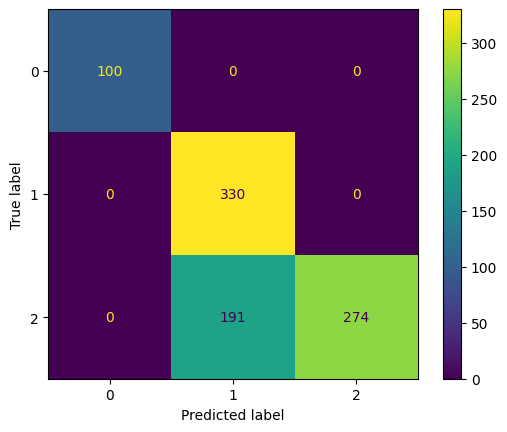

In [121]:
# Testing and visualising our random forest
print(accuracy_score(Y_test.detach().cpu().numpy(),y_pred))
cm = confusion_matrix(Y_test.detach().cpu().numpy(), y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

The accuracy score is pretty good, especially when compared to the previous NN model. This model seems better than our neural network when it comes to classifying healthy patients and patients suffering from RA. Interestingly, the random forest missclassifies some of the 2(RA) dataset as 1 (SLE). This probably has to do with the high amount of features of the dataset

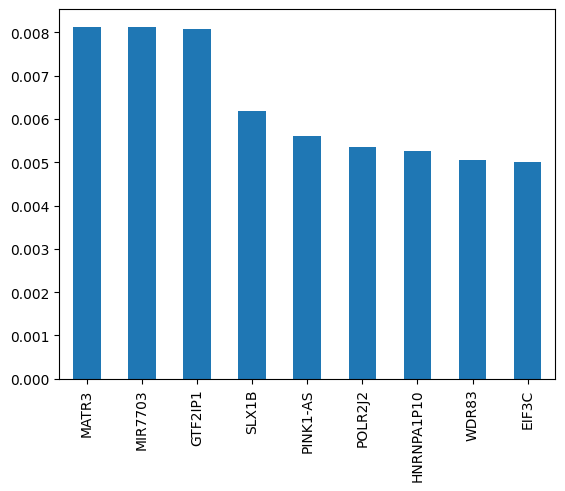

In [122]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(rf.feature_importances_, index=normalized_train_data.iloc[:,:].columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances[1:10].plot.bar();

There does not seem to be a huge outlier in genetic expression. This could be improved through better feature selection at the start.

In [123]:
# # Hyperparameters tuning 
# param_dist = {'n_estimators': randint(300,500),
#               'max_depth': randint(1,20)}
# # Use random search to find the best hyperparameters
# rand_search = RandomizedSearchCV(rf, 
#                                  param_distributions = param_dist, 
#                                  n_iter=10, 
#                                  cv=5)

# # Fit the random search object to the data
# rand_search.fit(X_train.detach().cpu().numpy(), Y_train.detach().cpu().numpy())
# # Create a variable for the best model
# best_rf = rand_search.best_estimator_

# # Print the best hyperparameters
# print('Best hyperparameters:',  rand_search.best_params_)



I ran this and got "Best hyperparameters: {'max_depth': 14, 'n_estimators': 484}". The computational time is quite long, and it could be improved further. 